In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transformers/transformers/distilbert-base-uncased/rust_model.ot
/kaggle/input/transformers/transformers/distilbert-base-uncased/config.json
/kaggle/input/transformers/transformers/distilbert-base-uncased/README.md
/kaggle/input/transformers/transformers/distilbert-base-uncased/tokenizer.json
/kaggle/input/transformers/transformers/distilbert-base-uncased/tf_model.h5
/kaggle/input/transformers/transformers/distilbert-base-uncased/tokenizer_config.json
/kaggle/input/transformers/transformers/distilbert-base-uncased/LICENSE.txt
/kaggle/input/transformers/transformers/distilbert-base-uncased/pytorch_model.bin
/kaggle/input/transformers/transformers/distilbert-base-uncased/vocab.txt
/kaggle/input/transformers/transformers/distilbert-base-uncased/gitattributes.txt
/kaggle/input/transformers/transformers/distilbert-base-uncased/flax_model.msgpack
/kaggle/input/transformers/transformers/longformer-base-4096/rust_model.ot
/kaggle/input/transformers/transformers/longformer-base-409

In [41]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.parsing.preprocessing import remove_stopwords

# 1. Data Load and Exploration

## Data Loading

In [42]:
DS_FOLDER = "../input/feedback-prize-english-language-learning"
train_df  = pd.read_csv(os.path.join(DS_FOLDER, "train.csv"))
test_df   = pd.read_csv(os.path.join(DS_FOLDER, "test.csv"))
sample_df = pd.read_csv(os.path.join(DS_FOLDER, "sample_submission.csv"))
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


## Exploration

### Score distribution

In [43]:
# SHow Distribution of Scores for each score type
def showDistributions(score_type='cohsion'):
    counts = dict(Counter(train_df[score_type]))
    print(f"{score_type} : {OrderedDict(sorted(counts.items()))}")
    plt.figure(figsize = (5,2))
    sns.countplot(x = train_df[score_type], palette = 'Set1', alpha = 0.8)
    plt.title(f'Distribution of {score_type} scores')
    plt.show()

cohesion : OrderedDict([(1.0, 10), (1.5, 27), (2.0, 315), (2.5, 790), (3.0, 1096), (3.5, 988), (4.0, 534), (4.5, 125), (5.0, 26)])


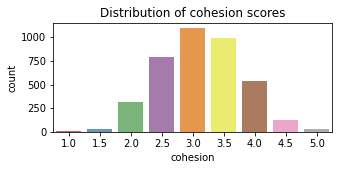

syntax : OrderedDict([(1.0, 11), (1.5, 29), (2.0, 410), (2.5, 839), (3.0, 1250), (3.5, 867), (4.0, 388), (4.5, 100), (5.0, 17)])


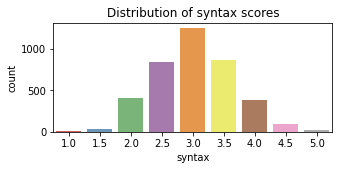

vocabulary : OrderedDict([(1.0, 2), (1.5, 14), (2.0, 124), (2.5, 528), (3.0, 1503), (3.5, 1007), (4.0, 577), (4.5, 115), (5.0, 41)])


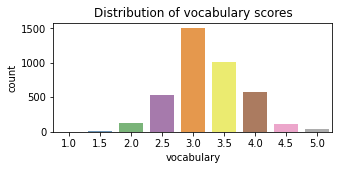

phraseology : OrderedDict([(1.0, 10), (1.5, 11), (2.0, 350), (2.5, 772), (3.0, 1153), (3.5, 929), (4.0, 553), (4.5, 108), (5.0, 25)])


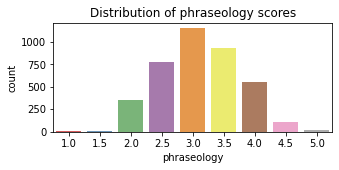

grammar : OrderedDict([(1.0, 8), (1.5, 20), (2.0, 544), (2.5, 855), (3.0, 994), (3.5, 880), (4.0, 447), (4.5, 134), (5.0, 29)])


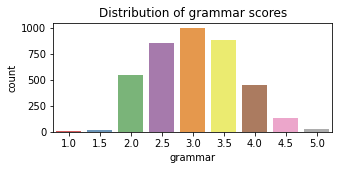

conventions : OrderedDict([(1.0, 15), (1.5, 20), (2.0, 402), (2.5, 784), (3.0, 1151), (3.5, 908), (4.0, 484), (4.5, 122), (5.0, 25)])


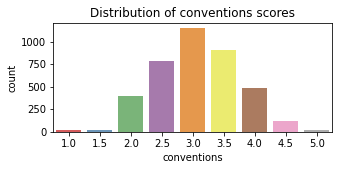

In [44]:
score_types = list(sample_df.columns)[1:]
for score_type in score_types:
    showDistributions(score_type)

The distribution indicates that it can be rather solved with Regression than Classification due to imbalance among classes. </br>
While score of '3.0' is the major among all score types, '1.0' and '5.0' are relatively small

### Word Count Distribution

In [45]:
# Show word counts for each essay
def showWordCounts(df):
    df['word_count'] = df['full_text'].progress_apply(lambda x: len(x.split()))
    maxWords = max(df['word_count'])
    print(f"\nMaximum words in a text is {maxWords}")

    plt.figure(figsize = (15,4))
    sns.histplot(df['word_count'], bins = range(0, 1400, 100), palette = 'Set1', alpha = 0.8)
    plt.title('Distribution of the word count')

    del df['word_count']

100%|██████████| 3911/3911 [00:00<00:00, 52099.27it/s]



Maximum words in a text is 1260


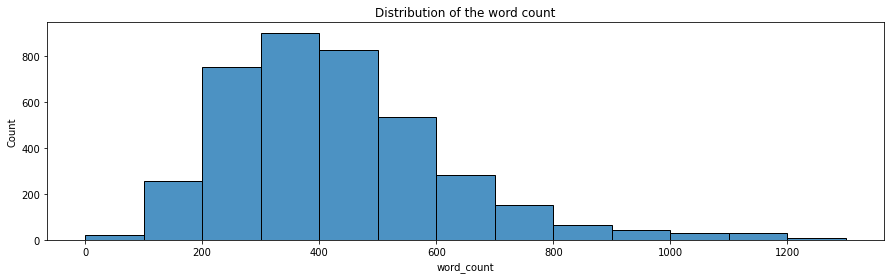

In [46]:
showWordCounts(train_df)

### Correlation of score types

<AxesSubplot:>

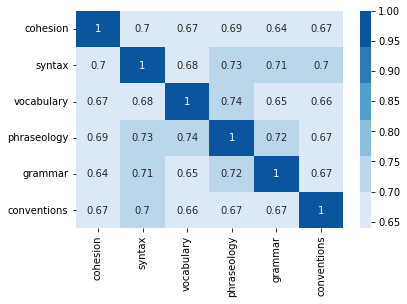

In [47]:
# Defining how required variables correlate to our target variable
corr = train_df[score_types].corr()
colormap = sns.color_palette('Blues')
sns.heatmap(corr, annot=True, cmap=colormap)

# 2. Feature Engineering

In [48]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

# Text cleaning
def cleanText(df, toLower=True, removeSquareBrackets=False, removeHyperlink=False, replaceContractions=False, removePuncutation=False, removeNumberWords=False, removeStopwords=False):
    if toLower:
        df.full_text= df.full_text.apply(lambda x:x.lower() )
    if removeSquareBrackets:
        #removing square brackets
        df.full_text= df.full_text.apply(lambda x:re.sub('\[.*?\]', '', x) )
        df.full_text= df.full_text.apply(lambda x:re.sub('<.*?>+', '', x) )
    if removeHyperlink:
        #removing hyperlink
        df.full_text= df.full_text.apply(lambda x:re.sub('http[s]?://\S+|www\.\S+', '', x) )
    if replaceContractions:
        df.full_text= df.full_text.apply(lambda x:replace_contractions(x))
    if removePuncutation:
        #removing puncuation
        df.full_text = df.full_text.apply(lambda x:re.sub(r"[,.;@#?!&$]+\ *", " ", x) )
    if removeNumberWords:
        #remove words containing numbers
        df.text= df.text.apply(lambda x:re.sub('\w*\d\w*' , '', x) )
    if removeStopwords:
        #remove stopwords
        df.full_text= df.full_text.apply(lambda x: remove_stopwords(x))
    return df

# 3. Model Deployment

In [49]:
import torch

config = {
    'model': '../input/transformers/transformers/longformer-base-4096',
    'dropout': 0.5,
    'max_length': int(512),
    'batch_size': 8,
    'epochs': 5,
    'lr': 5e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'scheduler': 'CosineAnnealingWarmRestarts',
    'toLower' : True,
    'removeSquareBrackets': False,
    'removeHyperlink' : False,
    'removePuncutation' : True,
    'removeNumberWords' : False,
    'removeStopwords' : True
}

In [50]:
import re

cleaned_train = train_df.copy()
cleaned_test = test_df.copy()

cleaned_train = cleanText(cleaned_train, 
                          toLower=config['toLower'], 
                          removeSquareBrackets=config['removeSquareBrackets'], 
                          removeHyperlink=config['removeHyperlink'], 
                          removePuncutation=config['removePuncutation'], 
                          removeNumberWords=config['removeNumberWords'], 
                          removeStopwords=config['removeStopwords'])

cleaned_test = cleanText(cleaned_test, 
                          toLower=config['toLower'], 
                          removeSquareBrackets=config['removeSquareBrackets'], 
                          removeHyperlink=config['removeHyperlink'], 
                          removePuncutation=config['removePuncutation'], 
                          removeNumberWords=config['removeNumberWords'], 
                          removeStopwords=config['removeStopwords'])

100%|██████████| 3911/3911 [00:00<00:00, 102821.42it/s]



Maximum words in a text is 480


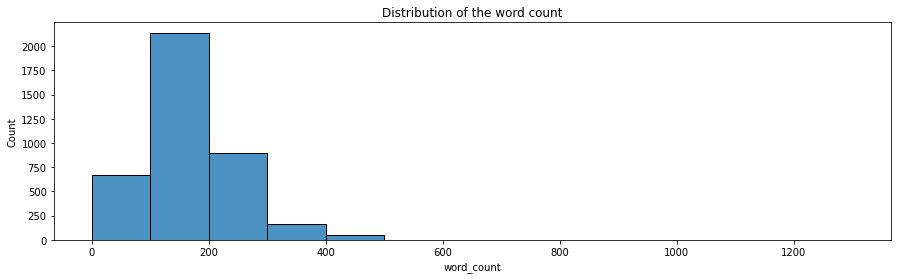

In [51]:
showWordCounts(cleaned_train)

In [52]:
# Train and Validation Split
from sklearn.model_selection import train_test_split

train, val = train_test_split(cleaned_train, test_size = 0.2, shuffle=True)
print('dataframe shapes:',train.shape, val.shape)

dataframe shapes: (3128, 8) (783, 8)


In [53]:
import torch
import torch.nn as nn
from transformers import LongformerTokenizer, LongformerModel
from transformers import AutoTokenizer, AutoModel

class EssayClassification(nn.Module):
    def __init__(self, config, num_classes=6):
        super(EssayClassification, self).__init__()
        self.model_name = config['model']
        self.encoder = LongformerModel.from_pretrained(self.model_name)
        self.dropout = nn.Dropout(config['dropout'])
        self.fc1 = nn.Linear(self.encoder.config.hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, inputs):
        _, outputs = self.encoder(**inputs, return_dict=False)
        outputs = self.dropout(outputs)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        return outputs

In [54]:
model = EssayClassification(config, num_classes=6)
tokenizer = LongformerTokenizer.from_pretrained(config['model'])

Some weights of the model checkpoint at ../input/transformers/transformers/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
class EssayDataset:
    def __init__(self, df, config, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
        self.max_len = config['max_length']
        self.tokenizer = tokenizer
        self.is_test = is_test
        
    def __getitem__(self,idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                          None,
                                          add_special_tokens=True,
                                          max_length=self.max_len,
                                          truncation=True,
                                          padding='max_length',
                                         )
        inputs = {
            "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long),
            #"token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        if self.is_test == True:
            return inputs
        
        label = self.df.loc[idx,self.classes].to_list()
        targets = {
            "labels": torch.tensor(label, dtype=torch.float32),
        }
        
        return inputs, targets
    
    def __len__(self):
        return len(self.df)

In [56]:
train_ds = EssayDataset(train, config, tokenizer=tokenizer)
val_ds = EssayDataset(val, config, tokenizer=tokenizer)
test_ds = EssayDataset(cleaned_test, config, tokenizer=tokenizer, is_test=True)

In [57]:
print(train.columns.to_list())

['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


In [58]:
train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=config['batch_size'],
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True
                                          )
val_loader = torch.utils.data.DataLoader(val_ds,
                                         batch_size=config['batch_size'],
                                         shuffle=True,
                                         num_workers=2,
                                         pin_memory=True
                                        )
test_loader = torch.utils.data.DataLoader(test_ds,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=2,
                                         pin_memory=True
                                        )

print('loader shapes:',len(train_loader), len(val_loader))

loader shapes: 391 98


In [59]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """
        :param val: value from the scores
        :param n  : batch_size
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [60]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.metrics = {}
        self.metrics['train_losses'] = []
        self.metrics['val_losses'] = []

        self.optimizer = self._get_optim()
        self.schedulers = {
            'CosineAnnealingWarmRestarts': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=5),
            'StepLR': torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=2, gamma=0.1),
            'ReduceLROnPlateau': torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer)
        }
        self.scheduler = self.schedulers[self.config['scheduler']]
    
    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config['lr'])
        return optimizer
    
    def fit(self):
        EPOCHS = self.config['epochs']
        for epoch in range(1, EPOCHS+1):
            print(f"\n Epoch: {epoch} / {EPOCHS}")
            self.train(epoch)
            self.validate(epoch)
            print(f"Train Loss: {self.metrics['train_losses'][-1]:.2} / Val Loss: {self.metrics['val_losses'][-1]:.2}")

    def loss_fn(self, outputs, targets):
            colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
            loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
            return loss

    def train(self, epoch):
        self.model.train()
        losses = AverageMeter()
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        iters = len(self.train_loader)

        for i,(inputs,targets) in enumerate(progress):
            # Initiate
            self.optimizer.zero_grad()
            inputs = {k:inputs[k].to(device=self.config['device']) for k in inputs.keys()}
            targets = targets['labels'].to(device=self.config['device']) 

            # Forward
            outputs = self.model(inputs)
            
            # Get Loss
            loss = self.loss_fn(outputs, targets)
            losses.update(loss.item(), len(targets))

            # Back Prop.
            loss.backward()

            # Update Weights
            self.optimizer.step()
            if self.config['scheduler'] == 'CosineAnnealingWarmRestarts':
                self.scheduler.step(epoch-1 + i / iters)
            elif self.config['scheduler'] == 'StepLR':
                self.scheduler.step()
        self.metrics['train_losses'].append(losses.avg)

    def validate(self, epoch):
        self.model.eval()
        losses = AverageMeter()
        progress = tqdm(self.val_loader, total=len(self.val_loader))

        with torch.no_grad():

            for i,(inputs,targets) in enumerate(progress):
                # Forward
                inputs = {k:inputs[k].to(device=self.config['device']) for k in inputs.keys()}
                targets = targets['labels'].to(device=self.config['device']) 

                # Forward
                outputs = self.model(inputs)

                # Get Loss
                loss = self.loss_fn(outputs, targets)
                losses.update(loss.item(), len(targets))

                # Keep track of metrics
                if self.config['scheduler'] == 'ReduceLROnPlateau':
                    self.scheduler.step(loss)
        self.metrics['val_losses'].append(losses.avg)

    def predict(self, test_loader):
        preds = []
        for (inputs) in test_loader:
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())
            
        preds = torch.concat(preds)
        return preds

In [61]:
model = model.to(device=config['device'])
trainer = Trainer(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    config = config
)

In [ ]:
trainer.fit()


 Epoch: 1 / 5


 80%|███████▉  | 312/391 [04:01<01:00,  1.30it/s]

In [ ]:
preds = trainer.predict(test_loader)
preds_df = pd.DataFrame(preds.numpy(), columns=score_types)

In [ ]:
submission = pd.concat([test_df, preds_df], axis=1)
submission_cols = ['text_id'] + score_types
submission = submission[submission_cols]
submission

In [ ]:
submission.to_csv("submission.csv", index=False)